In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense



2023-12-10 13:57:44.767733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 13:57:44.767786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 13:57:44.768424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 13:57:44.883147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 13:57:46.248236: W tensorflow/compiler/

In [2]:
nepali_stopwords = set(stopwords.words('nepali'))
english_stopwords = set(stopwords.words('english'))

In [3]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove specified characters
    text = re.sub('[#\\/।(),०-९<<?!,—–’‘:\u200d]', '', text)
    # Strip double quotes
    text = text.strip('"')

    # Tokenize the text
    words=word_tokenize(text)
    # Remove stop words for both Nepali and English
    filtered_words = [word for word in words if word.lower() not in nepali_stopwords and word.lower() not in english_stopwords]
    # Join the filtered words to form the processed text
    processed_text = ' '.join(filtered_words)
    return processed_text

In [4]:
df_final = pd.read_excel("dataset/updated_text_data.xlsx")
df_final['गुनासो'] = df_final['गुनासो'].apply(preprocess_text)

In [5]:
df_final['गुनासो वर्ग'].value_counts()


गुनासो वर्ग
वेबसाइट तथा अभिलेख व्यवस्थापन सम्बन्धी       2863
सोधपुछ, सुझाव, प्रशंसा सम्बन्धी              1899
कर्मचारी सम्वन्धी                            1384
स्वास्थ्यसँग सम्बन्धी                         899
अर्थ सबन्धी                                   856
खानेपानी सम्बन्धी                             770
सूचना तथा  संचार सम्बन्धी                     642
शान्ति सुरक्षा सम्बन्धी                       562
प्राकृतिक श्रोत/साधन सम्बन्धी                 233
लागु पदार्थ सम्बन्धी                          159
अर्थिक अनियमितता तथा भ्रष्टाचार सम्बन्धी       68
Name: count, dtype: int64

In [6]:
# Encoding Labels
le = LabelEncoder()
y = le.fit_transform(df_final['गुनासो वर्ग'])

In [7]:
word2vec_model_path="nepaliW2V_5Million.model"
word2vec_model=Word2Vec.load(word2vec_model_path)

In [11]:
# Function to convert text to vectors
def text_to_vector(text):
    vector = np.zeros(word2vec_model.vector_size)
    count = 0
    for word in word_tokenize(text):
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [12]:
df_final['गुनासो vector'] = df_final['गुनासो'].apply(text_to_vector)


In [13]:
df_final.sample(1)

,गुनासो वर्ग,गुनासो,गुनासो vector
1167,कर्मचारी सम्वन्धी,सल्यानको वनगाडकुपिन्डे नगरपालिकाको वडा कार्याल...,"[0.07385074737526122, 0.39267070112483843, -0...."


In [14]:
X = np.vstack(df_final['गुनासो vector'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from tensorflow.keras.layers import Flatten
model = Sequential()

# Assuming max_length is the maximum length of your sequences
model.add(LSTM(100, input_shape=(400
, word2vec_model.vector_size), activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))  # Add more LSTM layers if needed

# Flatten the output of the LSTM layers before feeding into Dense layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


ValueError: in user code:

    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nadika/Documents/Major/major_dataset_basanta_sir/venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 400, 200), found shape=(None, 200)


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

65/65 [==============================] - 0s 3ms/step - loss: 1.3329 - accuracy: 0.5515
Test Loss: 1.3329436779022217, Test Accuracy: 0.5515239238739014


In [ ]:
# Make predictions
new_complaint = "Your new complaint text here"
processed_complaint = preprocess_text(new_complaint)
vectorized_sequence = text_to_vector(processed_complaint)
vectorized_sequence = np.reshape(vectorized_sequence, (1, -1))  # Reshape for model input

prediction = model.predict(vectorized_sequence)
predicted_class = np.argmax(prediction)
predicted_category = le.inverse_transform([predicted_class])[0]
print(f"Predicted Category: {predicted_category}")

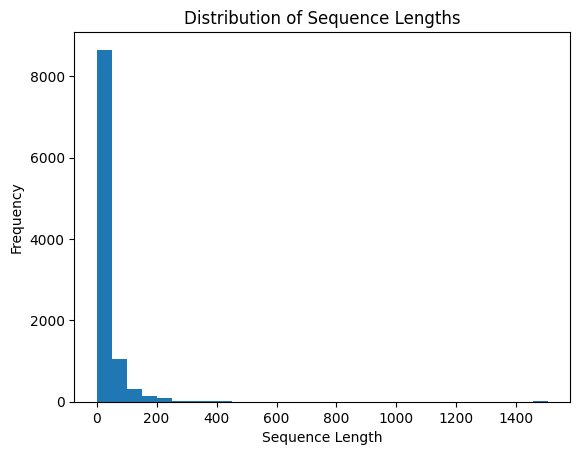

In [20]:
import matplotlib.pyplot as plt

# Assuming df_final['गुनासो'] contains your text data
sequence_lengths = df_final['गुनासो'].apply(lambda x: len(x.split()))

plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()